In [1]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, validation_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

from sklearn.tree import export_graphviz
import graphviz

In [2]:
plt.rc('font', family='NanumGothic', size=14)
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [3]:
member = pd.read_csv('member_data_preprocessed.csv')
product = pd.read_csv('product_preprocessed.csv')

# 전처리

In [4]:
X = pd.get_dummies(member.drop(['회원번호', '주소', '연령대', '구', '총구매금액', 'Gold_member', '1회평균구매금액', '주별평균구매금액'], axis=1))

In [281]:
X.columns

Index(['연령', '방문횟수', '반품횟수', '첫방문일', '최종방문일', '미방문기간', '방문주기', '구매증감율',
       '조합원상태_정상회원', '조합원상태_탈퇴', '조합원상태_탈퇴신청', '조합원상태_탈퇴처리중', '성별_남', '성별_여',
       '배송서비스신청여부_미신청', '배송서비스신청여부_신청', '모바일알람여부_미수신', '모바일알람여부_수신', '동_고림동',
       '동_공세동', '동_구갈동', '동_구미동', '동_궁내동', '동_금곡동', '동_금광동', '동_기타', '동_김량장동',
       '동_남사면', '동_단대동', '동_도촌동', '동_동백동', '동_동천동', '동_마북동', '동_마평동', '동_모현면',
       '동_백현동', '동_보라동', '동_보정동', '동_복정동', '동_분당동', '동_산성동', '동_삼가동', '동_삼평동',
       '동_상갈동', '동_상대원동', '동_상하동', '동_상현동', '동_서천동', '동_서현동', '동_성남동', '동_성복동',
       '동_수내동', '동_신갈동', '동_신봉동', '동_신흥동', '동_야탑동', '동_언남동', '동_여수동', '동_역북동',
       '동_영덕동', '동_오포읍', '동_원삼면', '동_위례(창곡)동', '동_위례동', '동_유방동', '동_율동',
       '동_은행동', '동_이동면', '동_이매동', '동_정자동', '동_죽전동', '동_중동', '동_중앙동', '동_지곡동',
       '동_청덕동', '동_태평동', '동_판교동', '동_풍덕천동', '동_하대원동', '최대매출매장_매장A',
       '최대매출매장_매장B', '최대매출매장_매장C', '최대매출매장_매장D'],
      dtype='object')

In [5]:
minmax = MinMaxScaler()

In [6]:
feature = minmax.fit_transform(X)

# 군집특성 파악

## k군집

In [7]:
km = KMeans(n_clusters=6, n_jobs=-1, random_state=1234)
km.fit(feature)
member['k군집'] = km.labels_

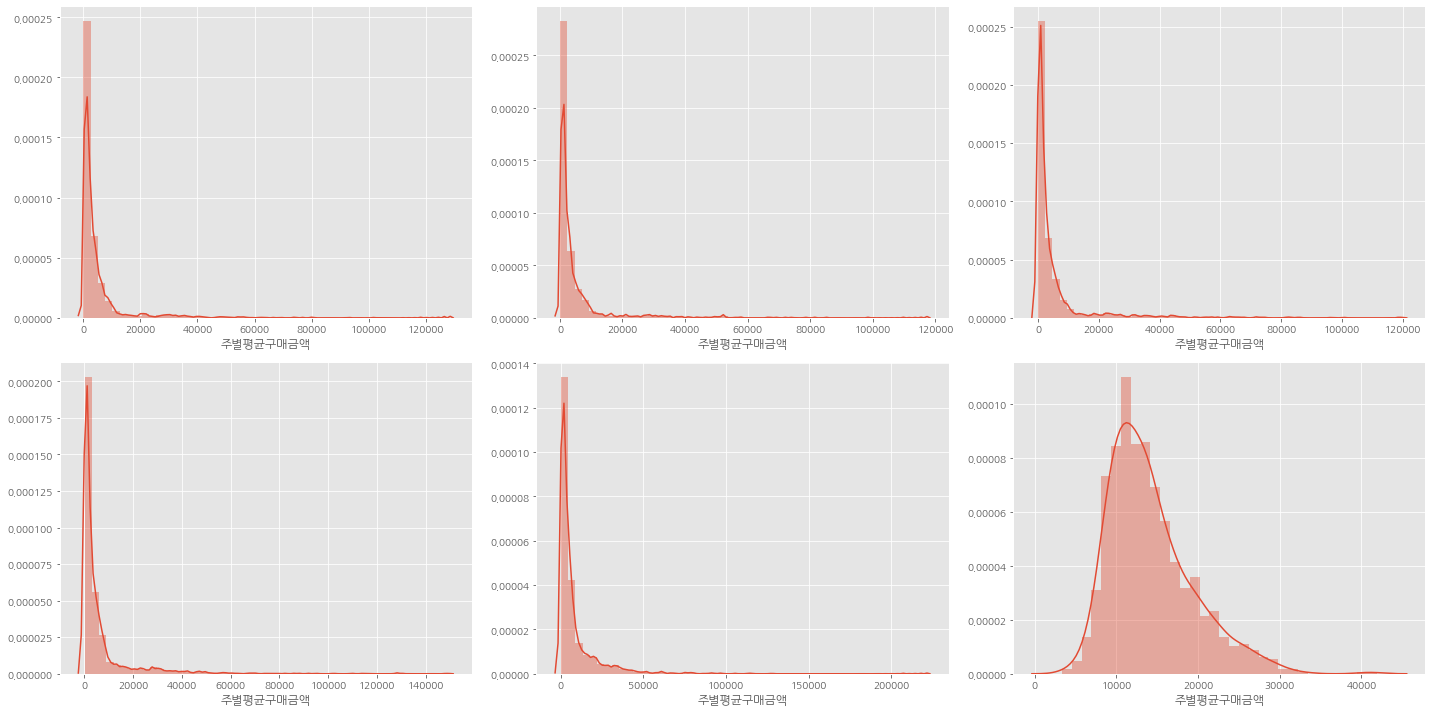

In [9]:
plt.figure(figsize=(20,10))
for i in range(6):
    sns.distplot(member.loc[member['k군집'] == i, '주별평균구매금액'], ax=plt.subplot(2, 3, i+1))
plt.tight_layout()

# VIP 분류 모델 생성

## k군집

In [10]:
member['VIP'] = 0

In [11]:
member.loc[member['k군집'] == 5, 'VIP'] = 1

In [12]:
member['VIP'].value_counts()

0    10499
1     1043
Name: VIP, dtype: int64

In [324]:
X_raw = pd.get_dummies(member.drop(['회원번호', '조합원상태', '주소', '배송서비스신청여부', 'Gold_member', '연령대', '구', '동', 'VIP', 'k군집', '총구매금액', '방문횟수', '첫방문일','최종방문일'], axis=1))
y_raw = member['VIP']

In [325]:
x_train, x_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, stratify=y_raw, random_state=1234)

In [326]:
dt = DecisionTreeClassifier(random_state=1234, max_depth=6)
rf = RandomForestClassifier(random_state=1234, n_jobs=-1, max_depth=7)
gb = GradientBoostingClassifier(random_state=1234, max_depth=3)
lgb = LGBMClassifier(max_depth=4)

In [327]:
dt.fit(x_train, y_train)
rf.fit(x_train, y_train)
gb.fit(x_train, y_train)
lgb.fit(x_train.values, y_train.values)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [328]:
print(f"의사결정나무 f1 점수 : {f1_score(y_test, dt.predict(x_test)).round(3)}\t 교차검증 점수 : {cross_val_score(dt, x_test, y_test, scoring='f1').mean().round(3)}")
print(f"랜덤포레스트 f1 점수 : {f1_score(y_test, rf.predict(x_test)).round(3)}\t 교차검증 점수 : {cross_val_score(rf, x_test, y_test, scoring='f1').mean().round(3)}")
print(f"그래디언트부스팅 f1 점수 : {f1_score(y_test, gb.predict(x_test)).round(3)}\t 교차검증 점수 : {cross_val_score(gb, x_test, y_test, scoring='f1').mean().round(3)}")
print(f"lightgbm f1 점수 : {f1_score(y_test, lgb.predict(x_test)).round(3)}\t 교차검증 점수 : {cross_val_score(lgb, x_test.values, y_test.values, scoring='f1').mean().round(3)}")

의사결정나무 f1 점수 : 0.741	 교차검증 점수 : 0.738
랜덤포레스트 f1 점수 : 0.75	 교차검증 점수 : 0.744
그래디언트부스팅 f1 점수 : 0.771	 교차검증 점수 : 0.752


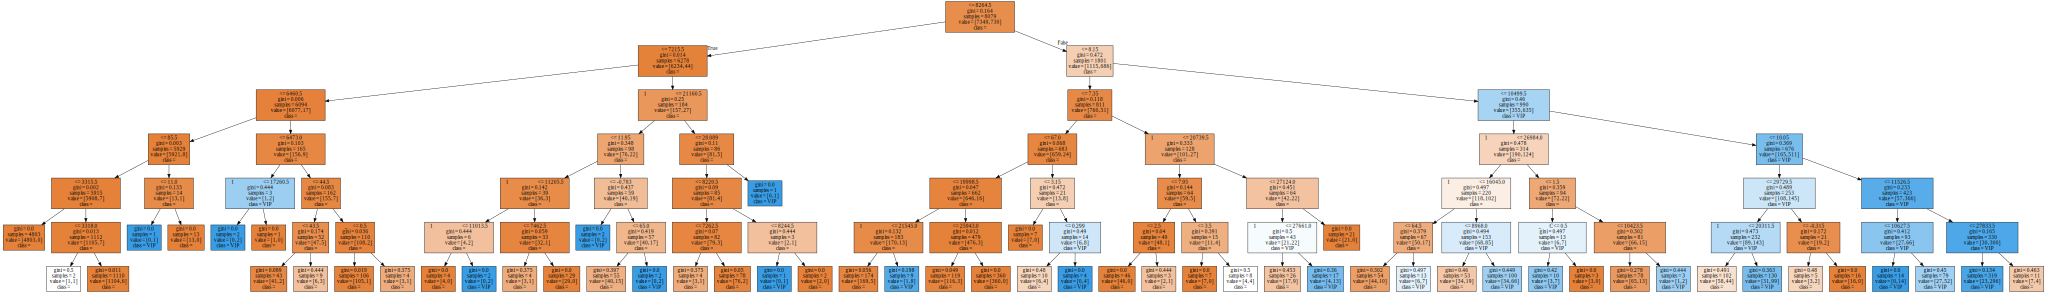

In [329]:
v_feature_name = x_train.columns
export_graphviz(dt, out_file='tree_low.dot', class_names=['일반', 'VIP'], feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_low.dot') as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

## max_depth 조절

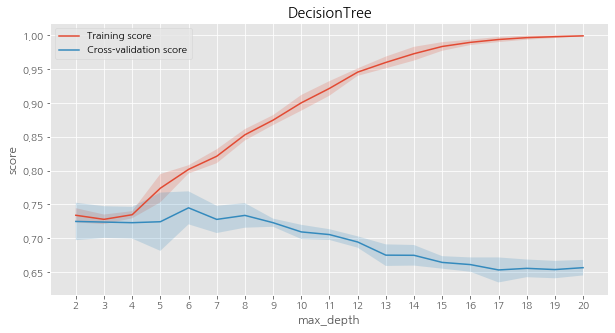

In [309]:
train_scores, test_scores = validation_curve(dt, X_raw, y_raw, param_name='max_depth', param_range=[i for i in range(2,21)], scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5),)
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('DecisionTree')
plt.show()

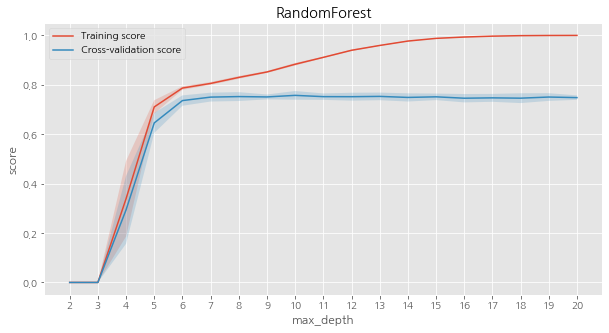

In [310]:
train_scores, test_scores = validation_curve(rf, X_raw, y_raw, param_name='max_depth', param_range=[i for i in range(2,21)], scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5),)
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('RandomForest')
plt.show()

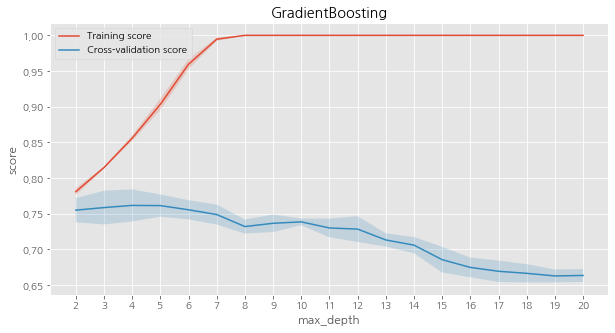

In [311]:
train_scores, test_scores = validation_curve(gb, X_raw, y_raw, param_name='max_depth', param_range=[i for i in range(2,21)], scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5),)
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('GradientBoosting')
plt.show()

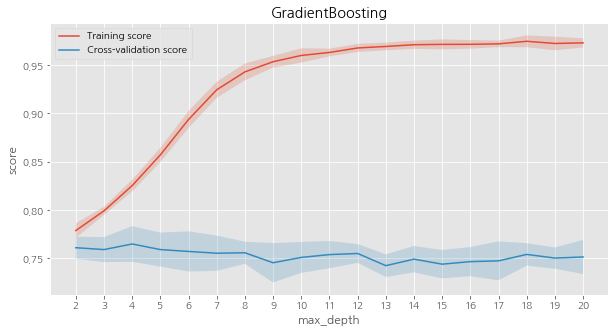

In [336]:
train_scores, test_scores = validation_curve(lgb, X_raw.values, y_raw.values, param_name='max_depth', param_range=[i for i in range(2,21)], scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5),)
plt.plot([i for i in range(2,21)], train_scores_mean, label="Training score")
plt.fill_between([i for i in range(2,21)], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([i for i in range(2,21)], test_scores_mean, label="Cross-validation score")
plt.fill_between([i for i in range(2,21)], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.xlabel('max_depth')
plt.xticks([i for i in range(2,21)])

plt.legend(loc="best")
plt.title('GradientBoosting')
plt.show()

## learning_rate 조절

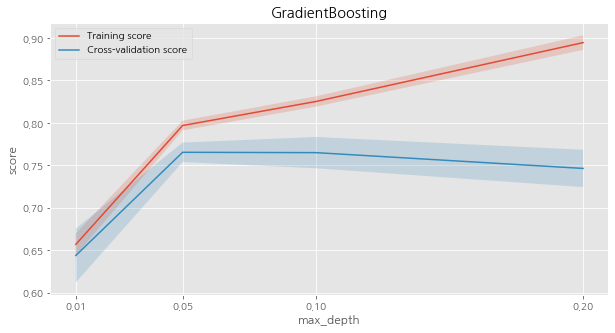

In [340]:
train_scores, test_scores = validation_curve(lgb, X_raw.values, y_raw.values, param_name='learning_rate', param_range=[0.01, 0.05, 0.1, 0.2], scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 5),)
plt.plot([0.01, 0.05, 0.1, 0.2], train_scores_mean, label="Training score")
plt.fill_between([0.01, 0.05, 0.1, 0.2], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot([0.01, 0.05, 0.1, 0.2], test_scores_mean, label="Cross-validation score")
plt.fill_between([0.01, 0.05, 0.1, 0.2], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.ylabel('score')
plt.xlabel('max_depth')
plt.xticks([0.01, 0.05, 0.1, 0.2])

plt.legend(loc="best")
plt.title('GradientBoosting')
plt.show()